In [229]:
import tsfresh
from tsfresh import extract_features
from sksurv.ensemble import RandomSurvivalForest
import sksurv
import time


In [2]:
# !pip install anamod
# %pip install tsfresh --user
# %pip install dfply
# %pip install scikit-survival

In [4]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.random import seed

os.getcwd()
import anamod
from anamod import TemporalModelAnalyzer


In [5]:
os.getcwd()


'/Users/hieu/Documents/CARDIA_longi_project/csv_files'

In [6]:

work_dir = '/home/idies/workspace/Storage/hnguye78/persistent/CARDIA_longi_project'
work_dir = '/Users/hieu/Documents/CARDIA_longi_project'
#data_file_name = 'data_longi_long_up_to_y15_prior_model_training'
data_file_name = 'data_longi_ascvd_for_dynamic_deephit'
load_dir = work_dir+ '/csv_files'

# load data:
data = pd.read_csv(load_dir+'/'+data_file_name+'.csv')
data = data.select_dtypes(include =[np.number])



In [7]:
data

,ID,event,exam_year,time,AGE_Y0,MALE,RACEBLACK,CHOL,DIAB,HBM,HDL,SBP,SMKNW
0,100033323702,0,0,32.134155,22,1,0,231,0,0,42,117.0,1
1,100033323702,0,2,32.134155,22,1,0,187,0,0,46,116.0,1
2,100033323702,0,5,32.134155,22,1,0,234,0,0,52,105.0,0
3,100033323702,0,7,32.134155,22,1,0,216,0,0,44,115.0,0
4,100033323702,0,15,32.134155,22,1,0,214,0,0,42,107.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20201,416817227898,0,2,31.770021,22,1,1,203,0,0,56,102.0,1
20202,416817227898,0,5,31.770021,22,1,1,204,0,0,43,133.0,1
20203,416817227898,0,7,31.770021,22,1,1,170,0,0,47,133.0,1
20204,416817227898,0,10,31.770021,22,1,1,179,0,0,47,112.0,0


In [8]:
data_ts = data.loc[:, ~data.columns.isin(['Unnamed: 0', 'event','time','RACEBLACK','MALE','AGE_Y0'])]
# data_ts.rename(columns={"exam_year": "time"}
data_ts


,ID,exam_year,CHOL,DIAB,HBM,HDL,SBP,SMKNW
0,100033323702,0,231,0,0,42,117.0,1
1,100033323702,2,187,0,0,46,116.0,1
2,100033323702,5,234,0,0,52,105.0,0
3,100033323702,7,216,0,0,44,115.0,0
4,100033323702,15,214,0,0,42,107.0,0
...,...,...,...,...,...,...,...,...
20201,416817227898,2,203,0,0,56,102.0,1
20202,416817227898,5,204,0,0,43,133.0,1
20203,416817227898,7,170,0,0,47,133.0,1
20204,416817227898,10,179,0,0,47,112.0,0


In [9]:
# convert from long format to 
varying_var =['CHOL','DIAB','HBM','HDL','SBP','SMKNW']
n_exam = 6
n_vars = 6
n_subjects = 3551

def convert_long_format_to_3d_matrix(data_ts_, n_exam_, n_varying_vars_, n_subjects_, varying_var_):

    desired_X = np.array([[[0 for k in range(n_exam_)] for j in range(n_varying_vars_)] for i in range(n_subjects_)])
    for i in range(0,n_varying_vars_):
        var_wide_df = data_ts_.pivot(index='ID', columns='exam_year', values=varying_var_[i])
        var_wide_df_locf = var_wide_df.T.fillna(method='ffill').T
        var_wide_locf_matrix = var_wide_df_locf.values
        desired_X[:,i,:] = var_wide_locf_matrix
    return(desired_X)


In [10]:
# this function doesn't work for smaller subset of subjects

def convert_3d_to_long_format(X, n_subjects_, varying_var_,exam_year_list_, unique_ids_arr_):
    for subject in range(0, n_subjects_): 
        if (subject == 0):
            all_subject_long_format = X[subject,:,:].T
        else:
            subject_long_format = desired_X[subject,:,:].T
            all_subject_long_format = np.concatenate((all_subject_long_format, subject_long_format))
    all_subject_long_format_df = pd.DataFrame(all_subject_long_format)
    all_subject_long_format_df.columns = varying_var_
    all_subject_long_format_df.insert(loc = 0, column = 'exam_year',
              value = exam_year_list_*n_subjects_)
    all_subject_long_format_df.insert(loc = 0, column = 'ID',
              value = [val for val in unique_ids_arr_ for _ in range(len(exam_year_list_))])
    return(all_subject_long_format_df)


desired_X = convert_long_format_to_3d_matrix(data_ts_ = data_ts, n_exam_ = n_exam, n_varying_vars_ = n_vars, n_subjects_ = n_subjects
                                            , varying_var_ = varying_var)
exam_year_list = [0, 2, 5, 7, 10, 15]
unique_ids_arr_all = np.unique(data['ID'])
# reconstructed_data_ts_long_format = convert_3d_to_long_format(X = desired_X, n_subjects_ = n_subjects
#                                                              ,varying_var_ = varying_var
#                                                              ,exam_year_list_ = exam_year_list
#                                                              ,unique_ids_arr_ =unique_ids_arr)



# reconstructed_data_ts_long_format

In [78]:
unique_ids_arr_all = np.unique(data['ID'])


In [73]:
reconstructed_data_ts_long_format = convert_3d_to_long_format(desired_X[38:43,:,:] 
                                                             , n_subjects_ = 5
                                                             ,varying_var_ = varying_var
                                                             ,exam_year_list_ = exam_year_list
                                                             ,unique_ids_arr_ = )
len(np.unique(reconstructed_data_ts_long_format['ID']))


5

In [11]:
# load tsfeatures data:
tsfeatures = pd.read_csv(work_dir+ '/csv_files'+'/'+'tsfresh_features_drop_nonunique_drop_na_relevant_df_drop_correlated'+'.csv')
tsfeatures = tsfeatures.select_dtypes(include =[np.number])
tsfeatures_vars = tsfeatures.columns[1:].values

# load outcome labels and static data:
# data_for_training_tsfeatures_models = pd.read_csv(work_dir+ '/csv_files'+'/'+'data_for_training_tsfeatures_models'+'.csv') 

In [12]:
data_outcome_and_static = data.loc[data['exam_year'] == 15][['ID','event','time','AGE_Y0','MALE','RACEBLACK']]
data_outcome_and_static['time'] = data_outcome_and_static['time']-15
data_outcome_and_static['AGE_Y15'] = data_outcome_and_static['AGE_Y0']+15
data_outcome_and_static = data_outcome_and_static.drop(['AGE_Y0'], axis = 1)
data_outcome_and_static = data_outcome_and_static[['ID','event','time','AGE_Y15','MALE','RACEBLACK']]
data_outcome_and_static

,ID,event,time,AGE_Y15,MALE,RACEBLACK
4,100033323702,0,17.134155,37,1,0
10,100056526386,0,17.142368,43,1,1
16,100061300991,0,17.427105,35,1,1
22,100080112533,0,17.057495,35,1,1
28,100101126081,0,17.424367,43,0,1
...,...,...,...,...,...,...
20184,416752023336,0,16.704312,41,1,1
20190,416761219907,0,16.674196,45,0,0
20194,416783315386,0,16.690623,42,0,0
20199,416796224310,0,16.761807,42,0,1


In [13]:
def long_format_to_tsfeatures_df(df, tsfeatures_vars_):
    # extract all ts featurse using tsfresh:
    extracted_features = extract_features(df, column_id="ID", column_sort="exam_year")

    # filter out vars used in the RSF-tsfresh model:
    extracted_features_filter_features_in_model = extracted_features[tsfeatures_vars_]
    extracted_features_filter_features_in_model.reset_index(level=0, inplace=True)
    extracted_features_filter_features_in_model = extracted_features_filter_features_in_model.rename(columns={'index': 'ID'})
    
    return(extracted_features_filter_features_in_model)



In [16]:
# build rsf model:

# training_id_file_name = 'all_training_set_ID'
# validation_id_file_name = 'all_validation_set_ID'
# testing_id_file_name = 'all_testing_set_ID'
# # load training id:
# loaddir = work_dir+ '/csv_files'
# trainingid_all = pd.read_csv(loaddir+'/'+training_id_file_name+'.csv')
# validationid_all = pd.read_csv(loaddir+'/'+validation_id_file_name+'.csv')
# testingid_all = pd.read_csv(loaddir+'/'+testing_id_file_name+'.csv')


# fold = 0
# trainingid = trainingid_all.iloc[:,fold].values
# validationid = validationid_all.iloc[:,fold].values
# testingid = testingid_all.iloc[:,fold].values

# training_validation_id = np.concatenate([trainingid,validationid])

# train_df = data_for_training_tsfeatures_models.loc[data_for_training_tsfeatures_models['ID'].isin(training_validation_id),:]
# del train_df['ID']
# test_df = data_for_training_tsfeatures_models.loc[data_for_training_tsfeatures_models['ID'].isin(testingid),:]
# del test_df['ID']

# featurespace_train_df = train_df.drop(['time','event'],axis =1)
# featurespace_test_df = test_df.drop(['time','event'],axis =1)

# featurespace_train = train_df.drop(['time','event'],axis =1).values
# featurespace_test = test_df.drop(['time','event'],axis =1).values

# y_train = sksurv.util.Surv.from_dataframe('event', 'time', train_df)
# y_test = sksurv.util.Surv.from_dataframe('event', 'time', test_df)

y_all = sksurv.util.Surv.from_dataframe('event', 'time', data_outcome_and_static)



In [17]:
y_all.shape

(3551,)

In [19]:
# # check Harrel's C-index:
# rsf.score(featurespace_test_df, y_test) 


In [36]:
# # The predicted risk scores:
# y_pred = rsf.predict(featurespace_test_df)

/home/idies/miniconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomSurvivalForest was fitted without feature names
  warnings.warn(


In [58]:
def rsf_ts_reformat(X):
    # given a 3d matrix feature space format, convert to the data format ready to plug into RSF:
    
    # convert X from 3d matrix to long format:
    reconstructed_data_ts_long_format = convert_3d_to_long_format(X 
                                                                 , n_subjects_ = n_subjects
                                                                 ,varying_var_ = varying_var
                                                                 ,exam_year_list_ = exam_year_list
                                                                 ,unique_ids_arr_ = unique_ids_arr)

    # convert from long format to format readily to feed into RSF-tsfeatures:
    # by computing ts features from long format data, filter necessary features
    tsfeatures_for_rsf_df = long_format_to_tsfeatures_df(df = reconstructed_data_ts_long_format, tsfeatures_vars_ = tsfeatures_vars)
    # data_for_rsf = pd.concat([data_outcome_and_static[['ID', 'event', 'time', 'AGE_Y15','MALE','RACEBLACK']], tsfeatures_for_rsf_df], axis=1).merge(, on = 'ID', how = 'inner')
    data_for_rsf = data_outcome_and_static[['ID', 'event', 'time', 'AGE_Y15','MALE','RACEBLACK']].merge(tsfeatures_for_rsf_df, on = 'ID', how = 'inner')
    featurespace_df_for_rsf = data_for_rsf.drop(['ID','time','event'],axis =1)
    
    return(featurespace_df_for_rsf)

In [21]:
desired_X.shape

(3551, 6, 6)

In [106]:
def f_rsf_input_as_matrix(rsf_obj, X):
    surv = rsf_obj.predict_survival_function(X, return_array = True)
    last_pred_prob_surv = surv[:, -1]
    return last_pred_prob_surv

In [143]:
from sksurv.ensemble import RandomSurvivalForest

class RSF_TS():
    """Class implementing model API required by anamod"""
    def __init__(self, **kwargs):
        self.kwargs = kwargs
        self.rsf_ts = RandomSurvivalForest(**kwargs)
        
    def fit(self, X, y=None):
        
        X_rsf_format = rsf_ts_reformat(X)
        self.rsf_ts.fit(X_rsf_format, y)

        # y_rsf_format = sksurv.util.Surv.from_dataframe('event', 'time', data_for_training_tsfeatures_models)
        # self.rsf_ts.fit(X_rsf_format, y_rsf_format)

        
    def predict(self, X):
        """Perform prediction on input X (comprising one or more instances)"""
        # return self.ground_truth_model.predict(X, noise=self.noise_multiplier)
        X_rsf_format = rsf_ts_reformat(X)
        # preds = self.rsf_ts.predict(X_rsf_format)
        surv = self.rsf_ts.predict_survival_function(X_rsf_format, return_array = True)
        preds = surv[:, -1]
        return(preds)
    
    def score(self, X, y_label):
        X_rsf_format = rsf_ts_reformat(X)
        c_index = self.rsf_ts.score(X_rsf_format, y_label)
        return(c_index)

In [369]:
seed(1)
N_exp = 800
n_subjects= N_exp
unique_ids_arr = unique_ids_arr_all[:N_exp]

RSF_TS_obj_N_exp = RSF_TS(n_estimators=1001,
                   min_samples_split=10,
                   min_samples_leaf=15,
                   max_features="sqrt",
                   n_jobs=-1,
                   random_state=20)
RSF_TS_obj_N_exp.fit(desired_X[:N_exp,:,:], y_all[:N_exp]) 

Feature Extraction: 100%|███████████████████████| 20/20 [00:28<00:00,  1.44s/it]


In [381]:
data_outcome_and_static.iloc[:N_exp,:]['event'].value_counts()

0    734
1     66
Name: event, dtype: int64

In [382]:
66/800

0.0825

In [371]:
y_pred_N_exp = RSF_TS_obj_N_exp.predict(desired_X[:N_exp,:,:])

Feature Extraction: 100%|███████████████████████| 20/20 [00:27<00:00,  1.38s/it]


In [372]:
RSF_TS_obj_N_exp.score(desired_X[:N_exp,:,:], y_all[:N_exp])

Feature Extraction: 100%|███████████████████████| 20/20 [00:27<00:00,  1.38s/it]


0.92769545222279

In [373]:
y_pred_N_exp

array([0.9355914 , 0.78731404, 0.73023961, 0.97475367, 0.97436425,
       0.83377296, 0.48933169, 0.98752273, 0.97486522, 0.97229316,
       0.89012297, 0.8910597 , 0.98644584, 0.87054816, 0.85370826,
       0.91999258, 0.96249959, 0.85474709, 0.95492677, 0.85328436,
       0.87951864, 0.93249381, 0.91571556, 0.97686297, 0.70777537,
       0.94335061, 0.93309468, 0.89904912, 0.92486019, 0.88009904,
       0.88287496, 0.84479235, 0.9492844 , 0.9587316 , 0.9288701 ,
       0.89540123, 0.99074513, 0.81383047, 0.78836095, 0.93016398,
       0.75585149, 0.87193617, 0.68783369, 0.96177625, 0.90398087,
       0.94548657, 0.92701705, 0.93667711, 0.76309948, 0.92780032,
       0.94472116, 0.96874122, 0.86445244, 0.77806131, 0.87263376,
       0.9428803 , 0.86682603, 0.88750892, 0.93224716, 0.83698293,
       0.86502422, 0.69943045, 0.92796708, 0.87206674, 0.98357279,
       0.91828083, 0.84009683, 0.96033008, 0.94401031, 0.89425864,
       0.96303074, 0.61227952, 0.97014914, 0.89402847, 0.93498

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


<AxesSubplot:xlabel='y_hat', ylabel='Density'>

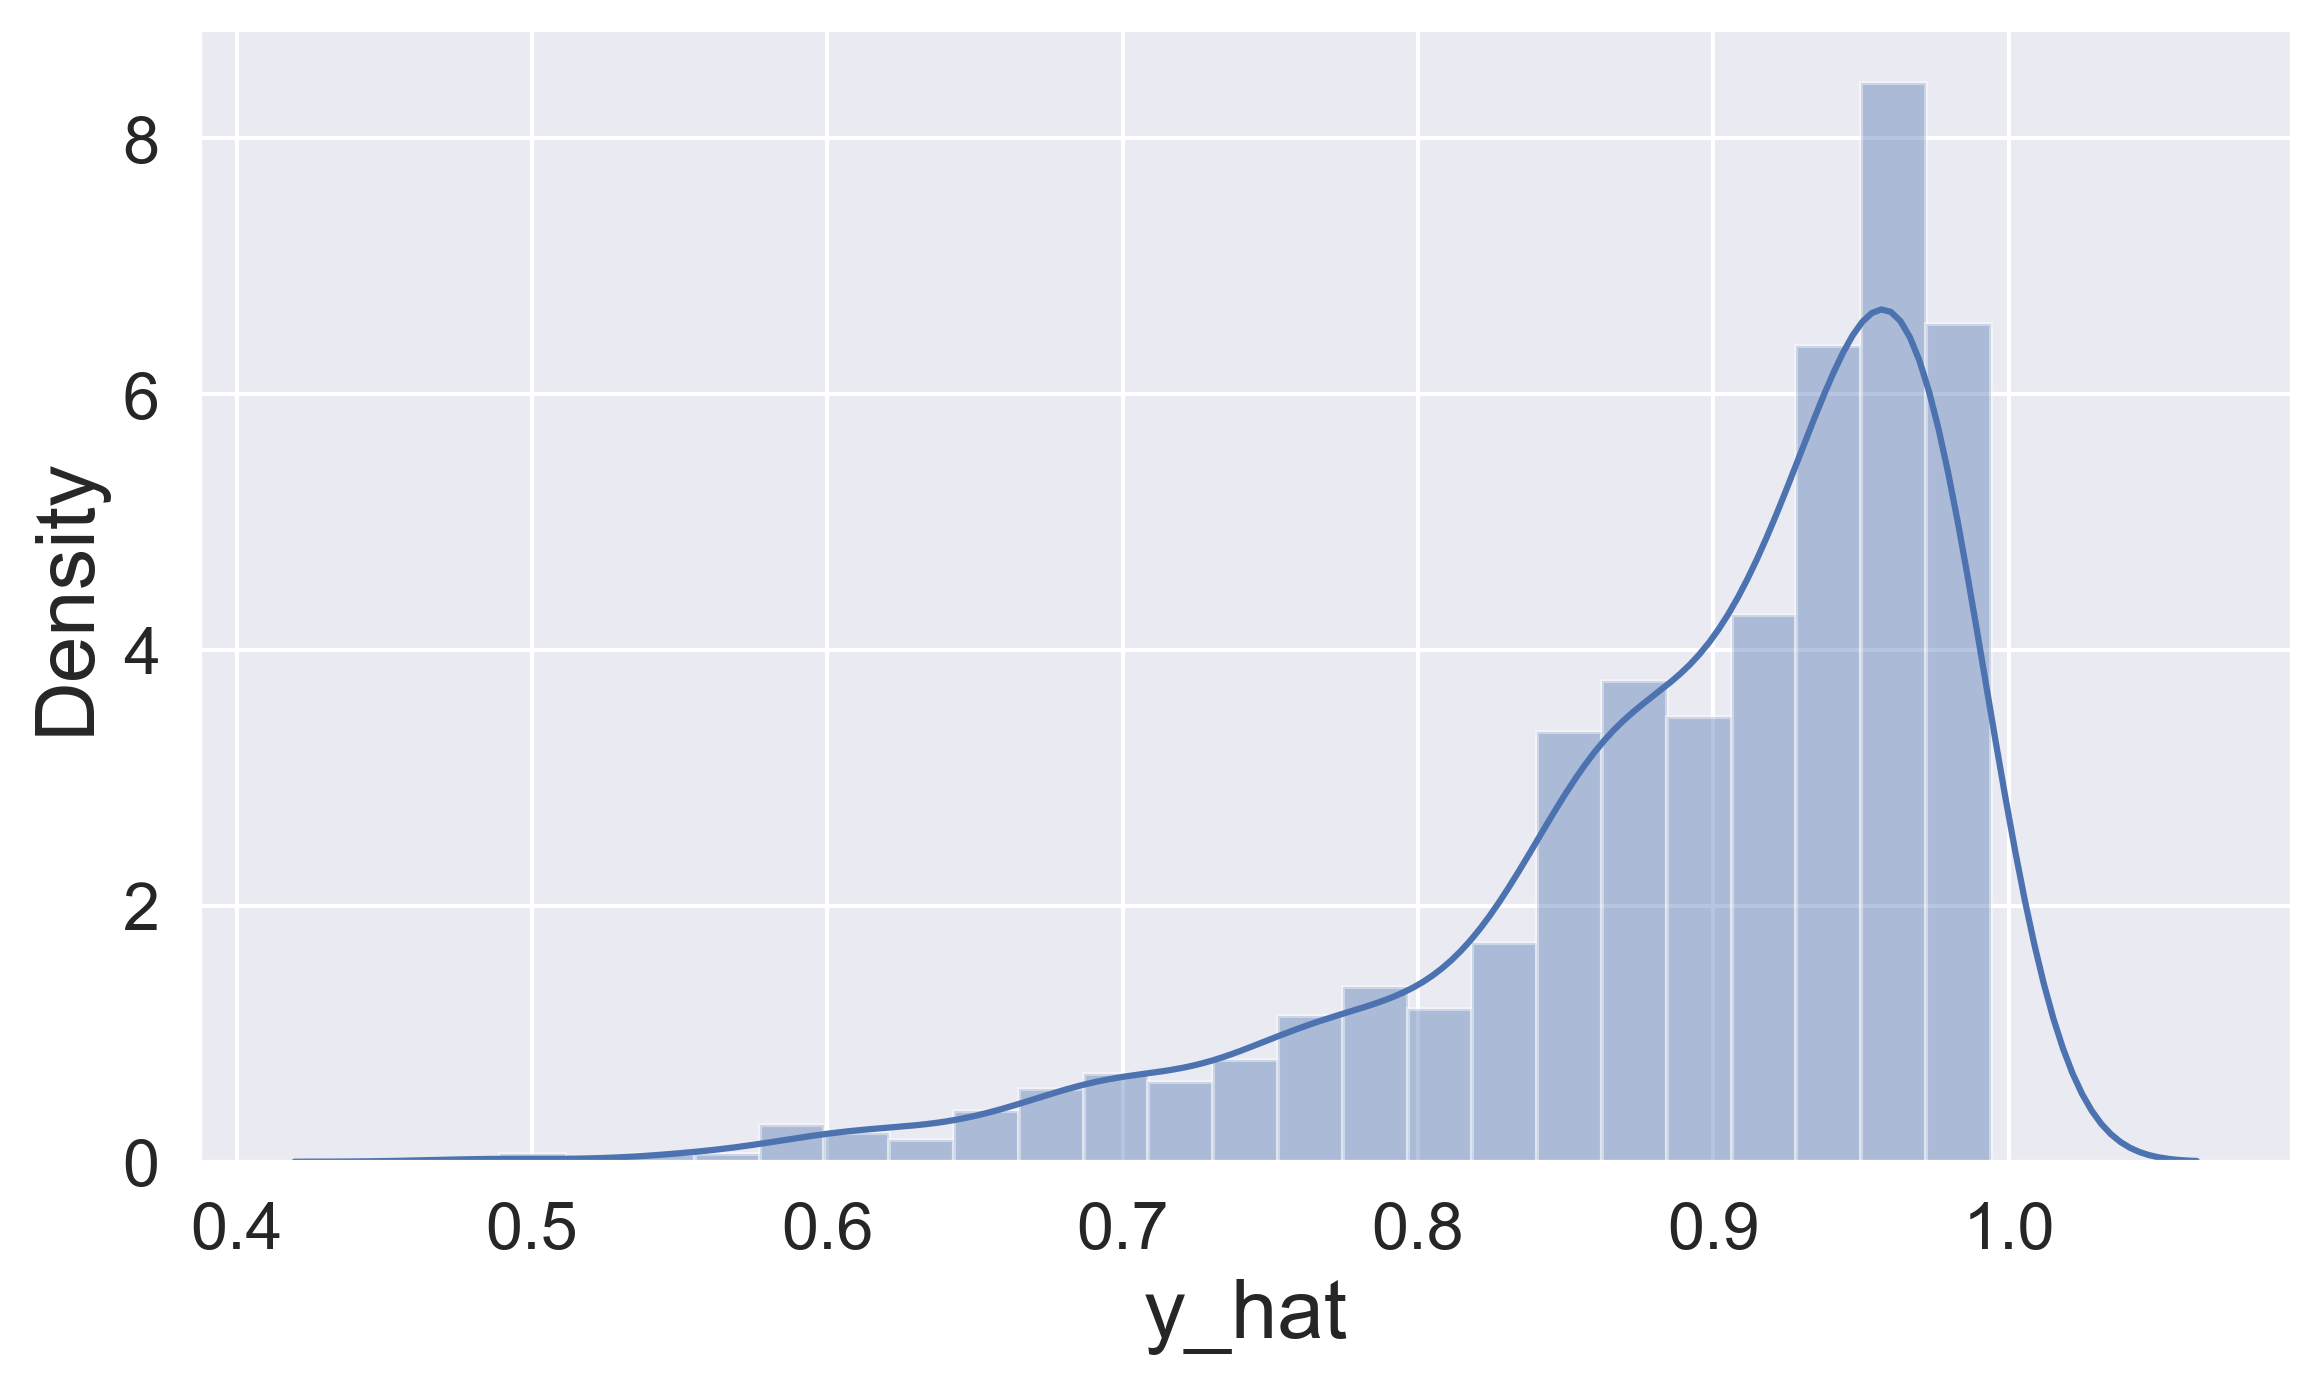

In [374]:
import seaborn as sns
import matplotlib.pyplot as plt
y_pred_df =pd.DataFrame(y_pred_N_exp, columns = ['y_hat'])
sns.distplot(y_pred_df.y_hat)

In [375]:
#filepath = os.getcwd() 
execfile("./model_analyzer_1.py")

Feature Extraction: 100%|███████████████████████| 20/20 [00:26<00:00,  1.35s/it]


Feature Extraction: 100%|███████████████████████| 20/20 [00:26<00:00,  1.35s/it]


Feature Extraction: 100%|███████████████████████| 20/20 [00:29<00:00,  1.47s/it]


Feature Extraction: 100%|███████████████████████| 20/20 [00:27<00:00,  1.35s/it]


Feature Extraction: 100%|███████████████████████| 20/20 [00:26<00:00,  1.34s/it]


Feature Extraction: 100%|███████████████████████| 20/20 [00:26<00:00,  1.35s/it]


Summary of important features: rsf_temporal_quadratic_loss_3_n_permute_50_pval_1_1_reverse_label_N_800/feature_importance.csv
Feature importance visualization: rsf_temporal_quadratic_loss_3_n_permute_50_pval_1_1_reverse_label_N_800/feature_importance_windows.png
65043.21481180191


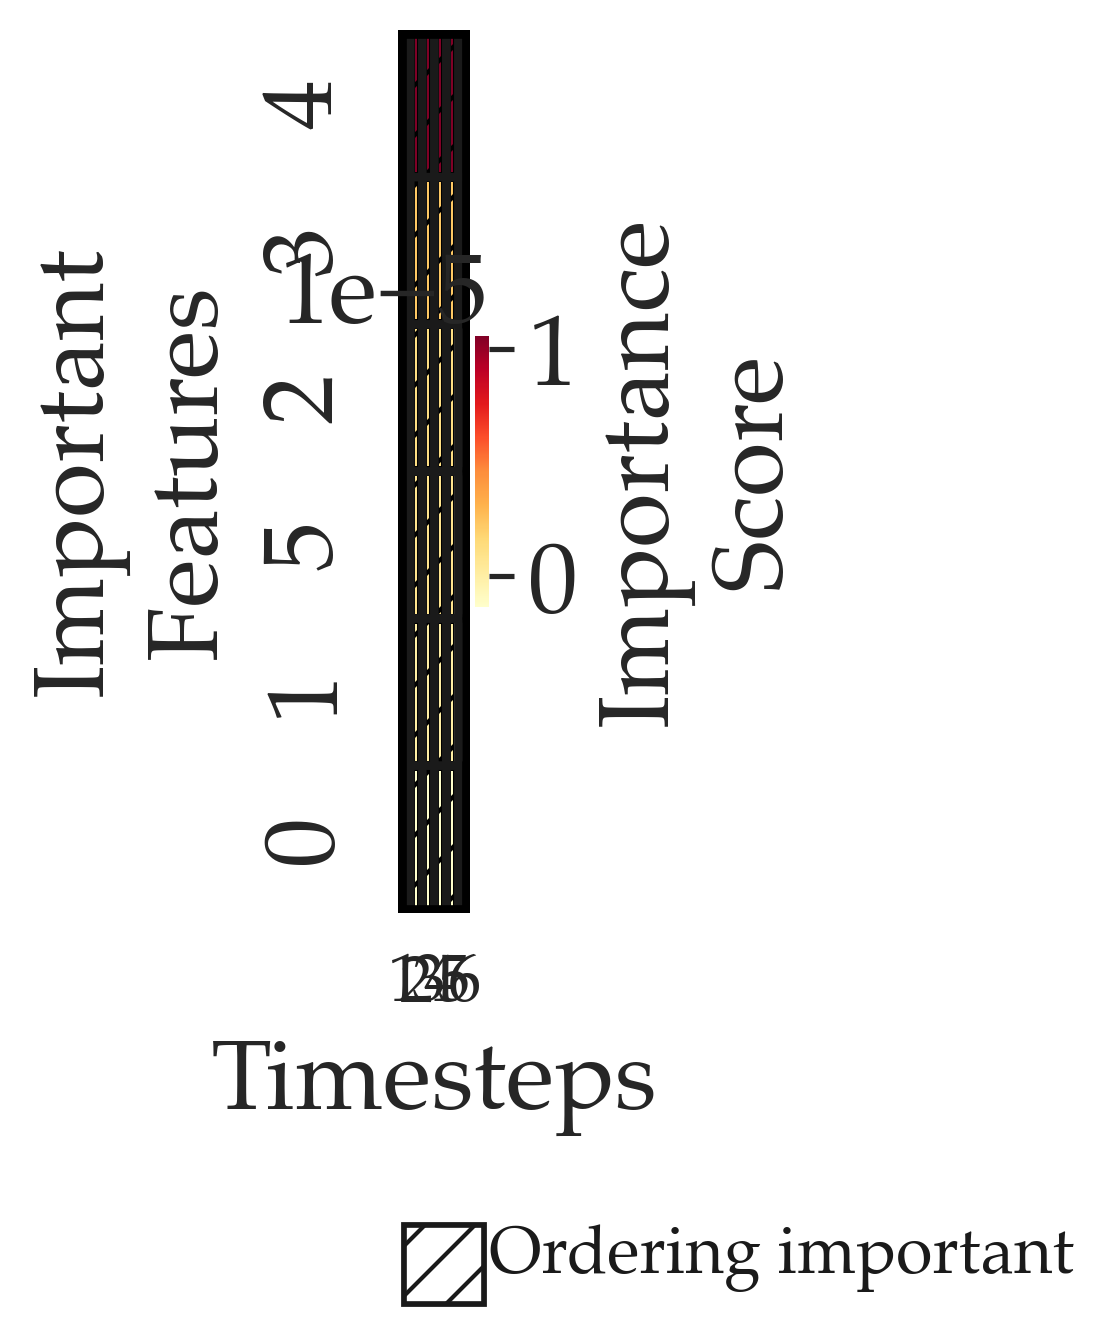

In [376]:
# Generate synthetic data and model
output_dir = "rsf_temporal_quadratic_loss_3_n_permute_50_pval_1_1_reverse_label_N_800"
# num_features = 10
# synthesized_features, X, model = synmod.synthesize(output_dir=output_dir, num_instances=100, seed=100,
#                                                     num_features=num_features, fraction_relevant_features=0.5,
#                                                     synthesis_type="temporal", sequence_length=20, model_type="regressor")
# y = model.predict(X, labels=True)

# Analyze the model
start = time. time()
rsf_analyzer = TemporalModelAnalyzer_1(RSF_TS_obj_N_exp, desired_X[:N_exp,:,:], 1-data_outcome_and_static.iloc[:N_exp,:]['event'], output_dir=output_dir)
features = rsf_analyzer.analyze()

end = time. time()
print(end - start)


In [378]:
print('Running time:' +str((end - start)/3600))

Running time:18.067559669944973


In [379]:
features_df = pd.read_csv("rsf_temporal_quadratic_loss_3_n_permute_50_pval_1_1_reverse_label_N_800"+'/'+'feature_importance.csv')
features_df['normalized_score'] = (abs(features_N_exp_df['importance_score'])-min(abs(features_N_exp_df['importance_score'])))/(max(abs(features_N_exp_df['importance_score']))-min(abs(features_N_exp_df['importance_score'])))
features_df.insert(loc=0, column='feature_name', value=varying_var)
features_df.loc[features_df['window_ordering_pvalue'] == 1, 'window_ordering_important'] = False
features_df

,feature_name,name,important,importance_score,pvalue,ordering_important,ordering_pvalue,window,window_important,window_importance_score,window_pvalue,window_ordering_important,window_ordering_pvalue,normalized_score
0,CHOL,0,True,-1.999068e-06,0.952381,True,0.666667,"(0, 5)",True,-1.385231e-06,0.809524,True,0.428571,0.119338
1,DIAB,1,True,2.882274e-07,0.952381,True,1.000000,"(0, 4)",True,2.733840e-08,1.000000,False,1.000000,0.000000
2,HBM,2,True,1.318592e-06,0.952381,True,1.000000,"(0, 4)",True,1.218533e-06,1.000000,False,1.000000,0.178323
3,HDL,3,True,4.270409e-06,0.952381,True,0.666667,"(0, 5)",True,2.306528e-06,0.666667,True,0.428571,0.296668
4,SBP,4,True,1.645553e-05,0.952381,True,0.380952,"(0, 5)",True,1.059286e-05,0.380952,True,0.476190,1.000000
5,SMKNW,5,True,1.641306e-06,0.952381,True,1.000000,"(0, 4)",True,7.723808e-07,1.000000,False,1.000000,0.299432


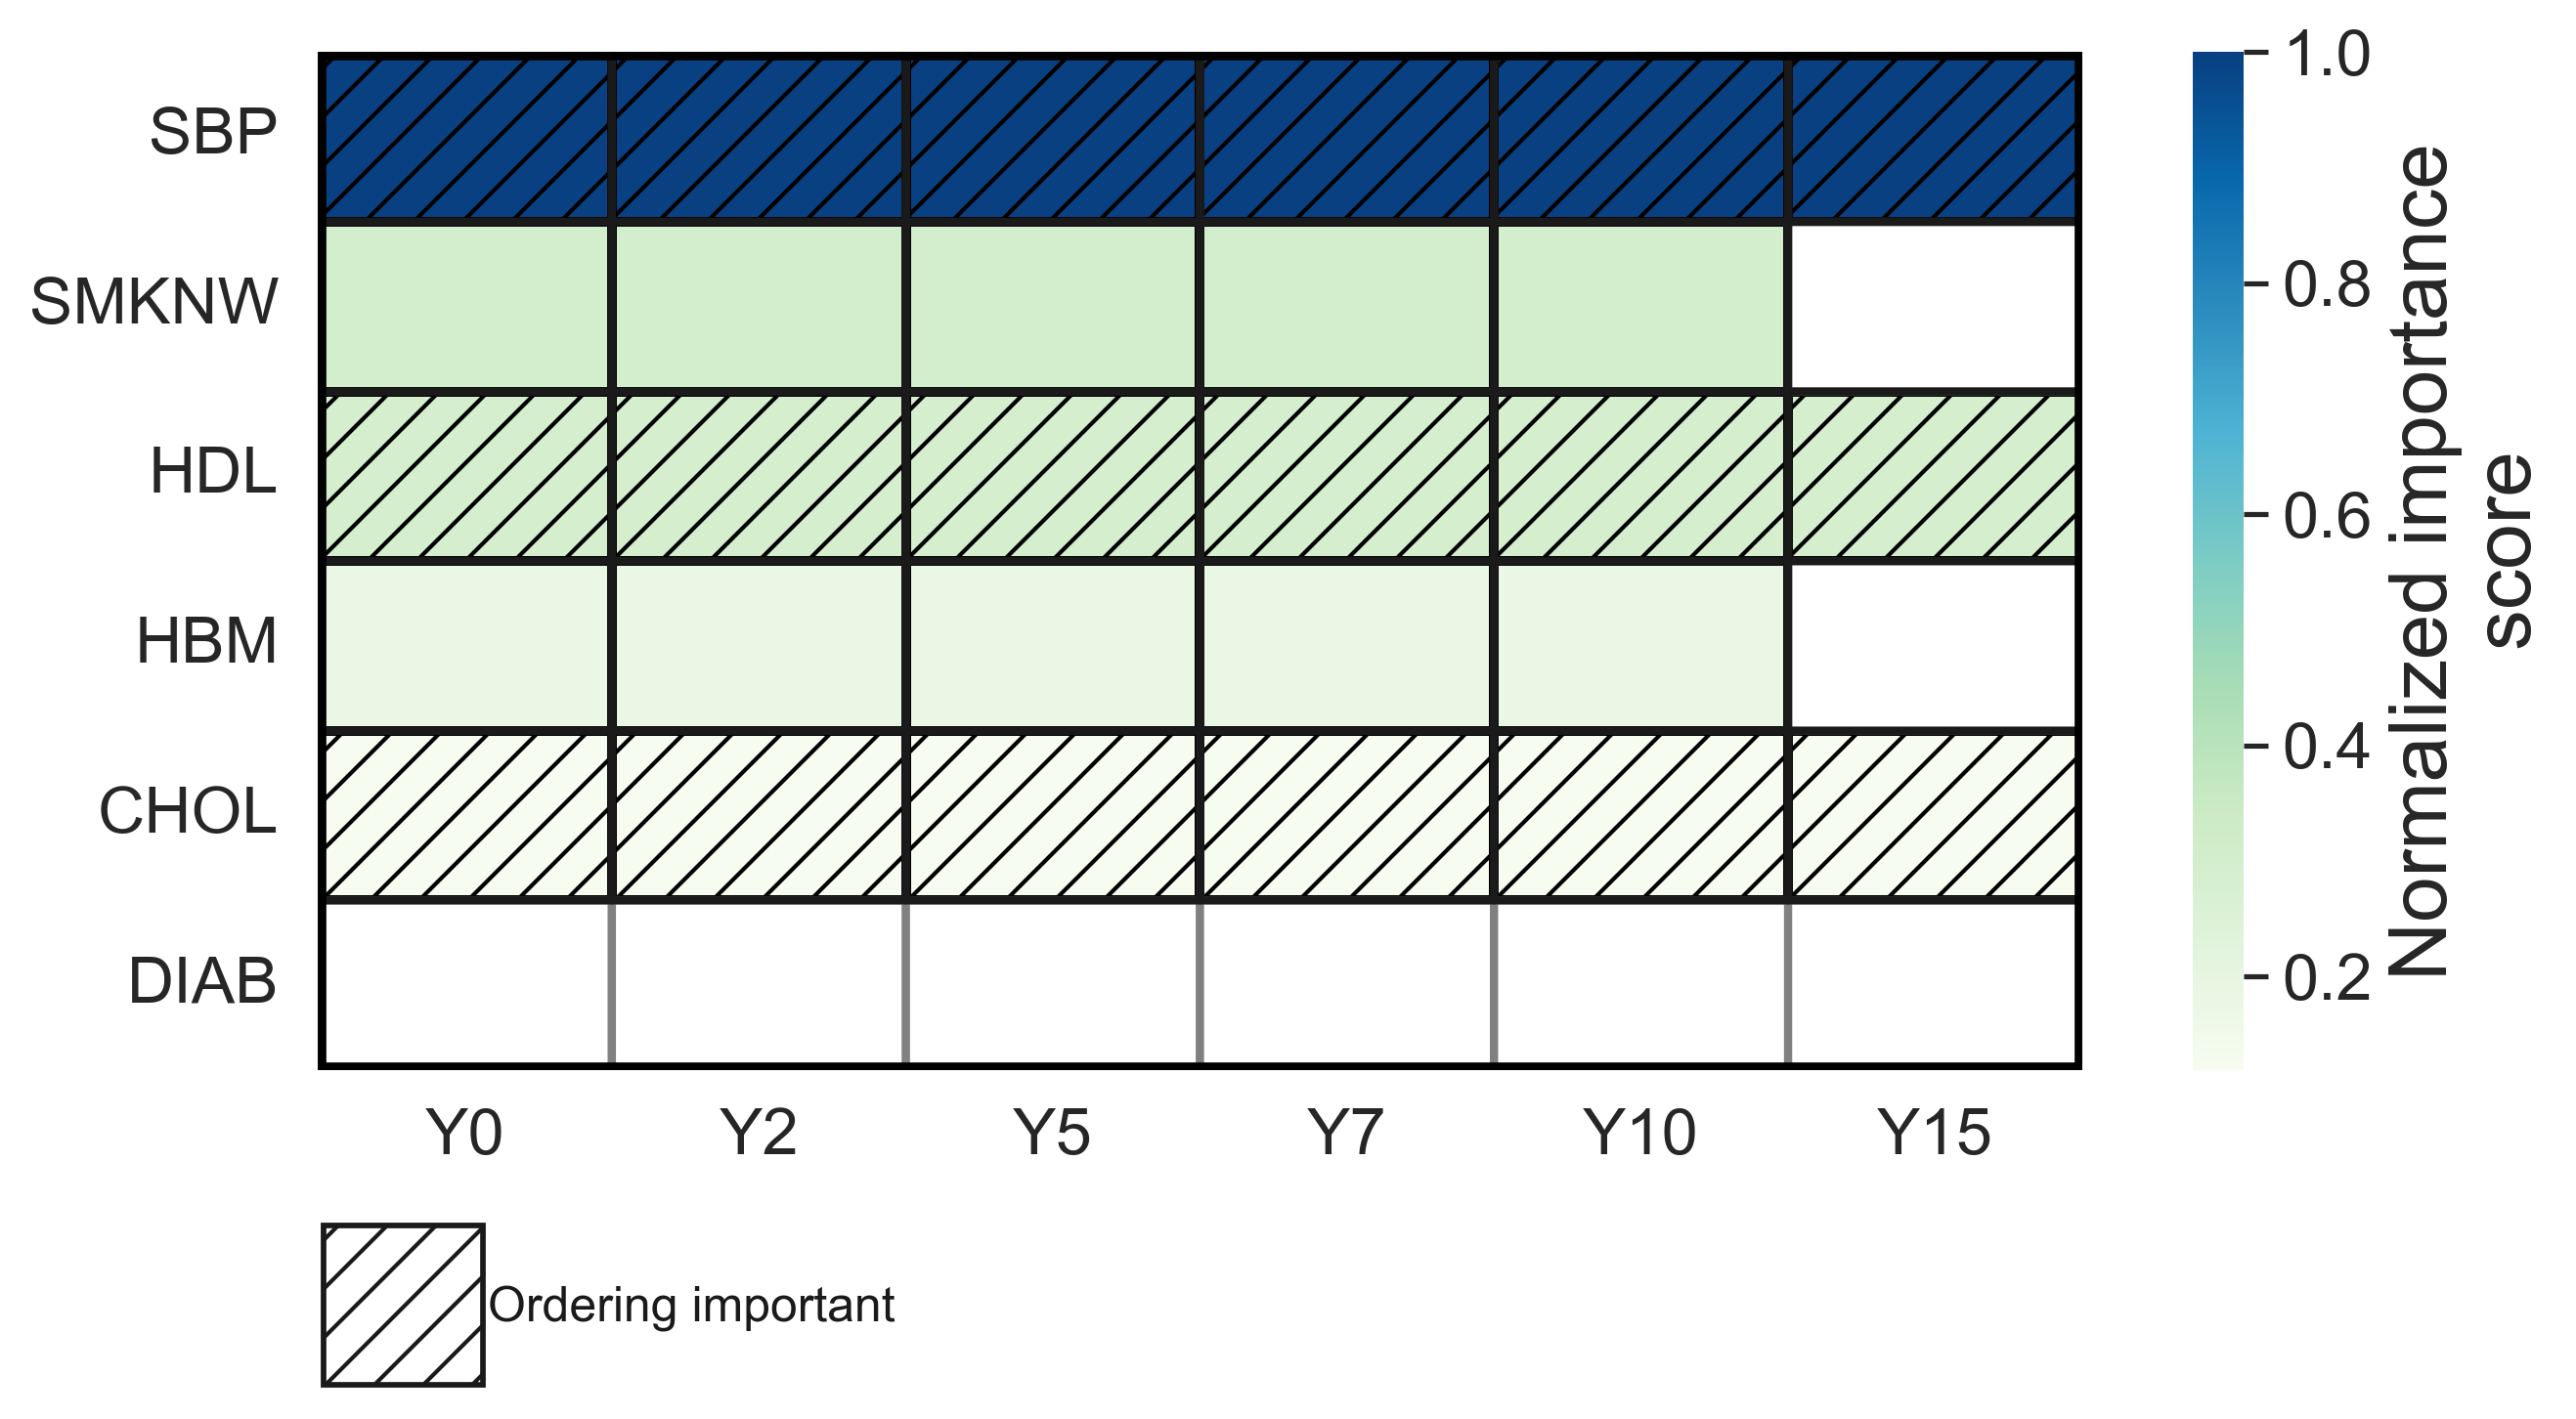

In [380]:

#def visualize_temporal(args, features, sequence_length):

"""Visualize temporal feature importance results"""

from matplotlib import patches 

sequence_length = n_exam
exam_label_arr = ['Y0', 'Y2', 'Y5', 'Y7', 'Y10', 'Y15']

# pylint: disable = invalid-name, too-many-locals
# features = list(filter(lambda feature: feature.important, features_N_exp))  # Filter out unimportant features
imp_features_df = features_df.loc[features_df['important'] == True]
num_features = imp_features_df.shape[0]

if num_features == 0:
    print("No important features identified, skipping window feature importance window visualization.")
#    return

sns.set(rc={'figure.figsize': (sequence_length / 2 *3, 2 + num_features / 2), 'figure.dpi': 300,
            #'font.family': 'Serif', 'font.serif': 'Palatino',
            'axes.titlesize': 24-14, 'axes.labelsize': 20, 'xtick.labelsize': 16, 'ytick.labelsize': 16})

# features = sorted(features, key=lambda feature: feature.window_effect_size, reverse=True)

sort_imp_features_df = imp_features_df.sort_values(by='normalized_score',ascending=False, ignore_index=True)

data = np.zeros((num_features, sequence_length))
hatchdata = np.zeros((num_features, sequence_length))

# labels = [feature.name for feature in features]
labels = sort_imp_features_df['feature_name']

for feature in range(len(labels)):
    if sort_imp_features_df['window'][feature]:
        left = int(sort_imp_features_df['window'][feature][1])
        right = int(sort_imp_features_df['window'][feature][4])
        data[feature, left:right+1] = sort_imp_features_df['normalized_score'][feature]
    if sort_imp_features_df['window_ordering_important'][feature] == True:
        hatchdata[feature, left: right + 1] = 1

        

# for idx, feature in enumerate(features):
#     if feature.temporal_window:
#         left, right = feature.temporal_window
#         data[idx, left: right + 1] = feature.window_effect_size
#     else:
#         data[idx] = feature.overall_effect_size
#     if feature.window_ordering_important:
#         hatchdata[idx, left: right + 1] = 1

_, axes = plt.subplots(2, 1, gridspec_kw={'height_ratios': [num_features, 1]})

sns.heatmap(data, yticklabels=labels, xticklabels= exam_label_arr#np.arange(1, sequence_length + 1)
            , mask=(data == 0), linewidth=2, linecolor="black"
            , cmap="GnBu" #"YlOrRd"
            , cbar_kws=dict(label="Normalized importance\n score"), ax=axes[0])


# Border lines
axes[0].axhline(y=0, color='black', linewidth=4)
axes[0].axhline(y=num_features, color='black', linewidth=4)
axes[0].axvline(x=0, color='black', linewidth=4)
axes[0].axvline(x=sequence_length, color='black', linewidth=4)
# Labels
# axes[0].set_title("Temporal Feature Importance")
# axes[0].set_xlabel("Timesteps")
# axes[0].set_ylabel("Important\nFeatures")
# Hatch texture for ordering relevance
x = np.arange(sequence_length + 1)
y = np.arange(num_features + 1)
z = np.ma.masked_equal(hatchdata, 0)
axes[0].pcolor(x, y, z, hatch='//', alpha=0.)
# Grey foreground for non-relevant timesteps
z = np.ma.masked_not_equal(data, 0)
axes[0].pcolor(x, y, z, cmap="Greys", linewidth=2, edgecolors="Grey")
# Fix edges of relevant timesteps
z = np.ma.masked_equal((data != 0), 0)
axes[0].pcolor(x, y, z, linewidth=2, edgecolor="k", facecolor="none", alpha=1.0)
# output_filename = f"{args.output_dir}/{constants.FEATURE_IMPORTANCE_WINDOWS}.png"

# Legend
axes[1].set_aspect(1, anchor="W")
axes[1].add_patch(patches.Rectangle((0, 0), 1, 1, facecolor="w", edgecolor="k", linewidth=4, hatch="//"))
axes[1].annotate("Ordering important", (1, 0.4), color="k"
                 # , weight="bold"
                 , fontsize=12)
axes[1].xaxis.set_ticklabels([])
axes[1].yaxis.set_ticklabels([])

# Plot
plt.tight_layout()
# plt.savefig(output_filename)
# print(f"Feature importance visualization: {output_filename}")
    
# visualize_temporal(args, features, sequence_length)

Summary of important features: example_synthetic_temporal/feature_importance.csv
Feature importance visualization: example_synthetic_temporal/feature_importance_windows.png


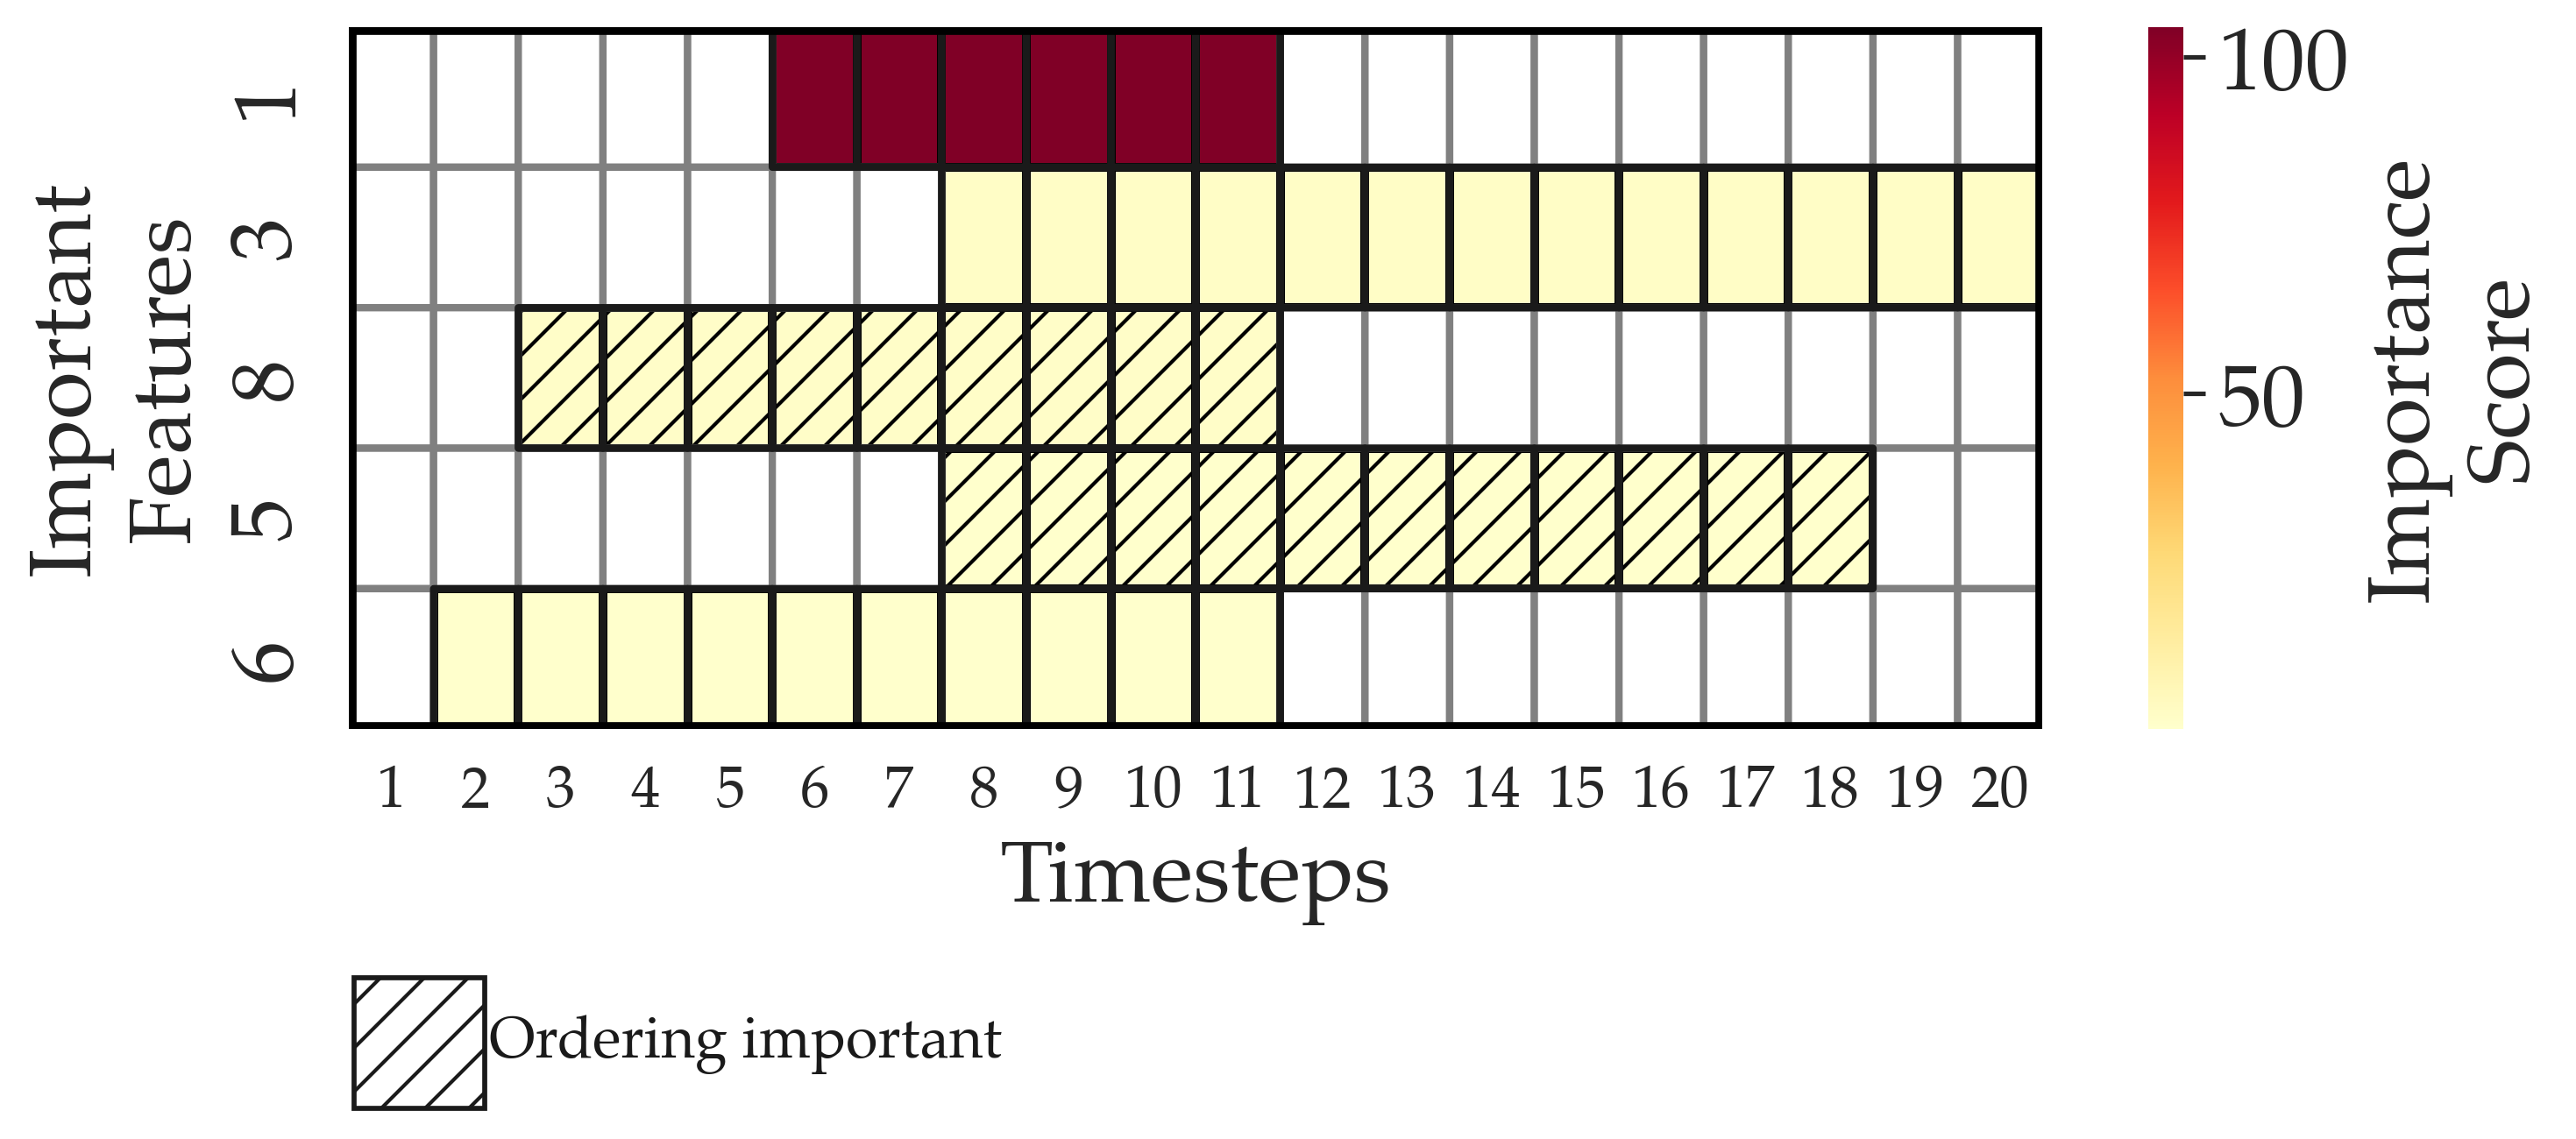

In [132]:
# Generate synthetic data and model
import synmod
output_dir = "example_synthetic_temporal"
num_features = 10
synthesized_features, X_sample, model_sample = synmod.synthesize(output_dir=output_dir, num_instances=100, seed=100,
                                                    num_features=num_features, fraction_relevant_features=0.5,
                                                    synthesis_type="temporal", sequence_length=20, model_type="regressor")
y_sample = model_sample.predict(X_sample, labels=True)

# Analyze the model
from anamod import TemporalModelAnalyzer
analyzer_sample = TemporalModelAnalyzer(model_sample, X_sample, y_sample, output_dir=output_dir)
features_sample = analyzer_sample.analyze()




Summary of important features: example_synthetic_temporal2/feature_importance.csv
Feature importance visualization: example_synthetic_temporal2/feature_importance_windows.png


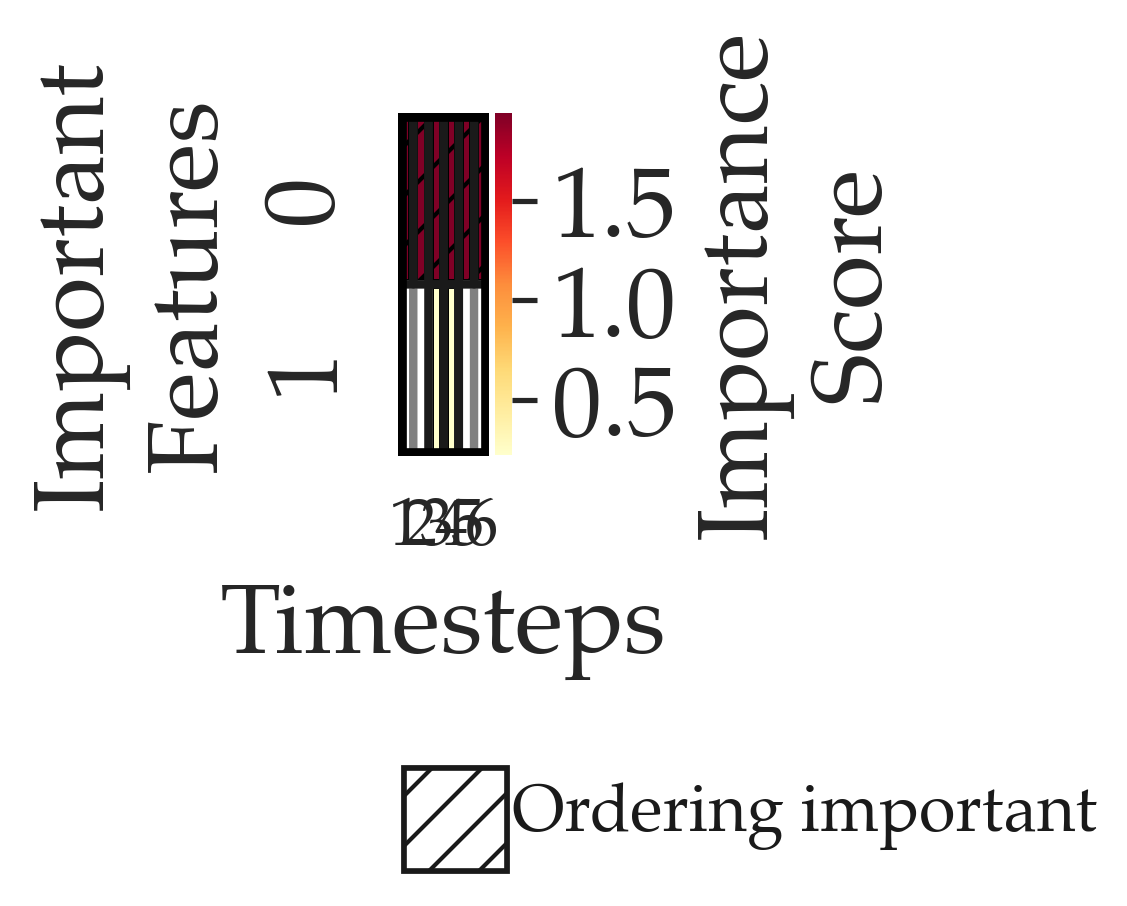

In [135]:
# Generate synthetic data and model
import synmod
output_dir = "example_synthetic_temporal2"
num_features = 6
synthesized_features, X_sample, model_sample = synmod.synthesize(output_dir=output_dir, num_instances=100, seed=100,
                                                    num_features=num_features, fraction_relevant_features=0.5,
                                                    synthesis_type="temporal", sequence_length=6, model_type="classifier") #regressor
y_sample = model_sample.predict(X_sample, labels=True)

# Analyze the model
from anamod import TemporalModelAnalyzer
analyzer_sample = TemporalModelAnalyzer(model_sample, X_sample, y_sample, output_dir=output_dir)
features_sample = analyzer_sample.analyze()

# Visualize feature importance for temporal windows


# Experiment with SHAP:

In [195]:
# import shap

In [ ]:
# Need a RSF_TS class that takes in a long format featurespace, spit prediction
# from the SHAP 2d matrix, need to convert to 3d matrix of shap values 
# --> average across time steps would get imp ranking for each patient --> beeswarm plot, averaging across patient will get bar plot
# --> or average across patients will get 2d matrix of features vs. timestep
# --> slice per subject, will get feature vs. timestep

# curr SHAP version would break the temporal dependent relationship 
# can Andrei's version be applied with non-RNN?

In [198]:
# def f_RSF_TS_predict(X):
#    return(RSF_TS_obj_N_exp.predict(X))


In [201]:
# explainer_shap = shap.KernelExplainer(f_RSF_TS_predict, desired_X[:N_exp,:,:])

Feature Extraction: 100%|███████████████████████| 20/20 [00:04<00:00,  4.82it/s]


In [203]:
# shap_value = explainer_shap.shap_values(desired_X[:10,:,:])

AssertionError: Instance must have 1 or 2 dimensions!

In [204]:
# explainer_shap_deep = shap.DeepExplainer(f_RSF_TS_predict, desired_X[:N_exp,:,:])

ModuleNotFoundError: No module named 'tensorflow'